<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_CNN_findGauss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# summary info on models
from torchsummary import summary

## Create Gaussian blurs with different widths

In [7]:
nGauss = 1000
imgSize = 91

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)


# initialize tensors containing images and labels
images = torch.zeros(nGauss, 1, imgSize, imgSize)
labels = torch.zeros(nGauss, 3)

for i in range(nGauss):

    # create the gaussian with random centers
    loc = 2*np.random.randn(2) # ro = random offset
    wid = np.random.rand() * 10 + 5

    # create the gaussian with random centers
    G = np.exp(-( (X-loc[0])**2 + (Y-loc[1])**2) / wid )
    # and add noise
    G = G + np.random.randn(imgSize, imgSize) / 10

    # add to the tensor
    images[i, :, :, :] = torch.Tensor(G).view(1, imgSize, imgSize)
    labels[i, :] = torch.Tensor([loc[0], loc[1], wid])



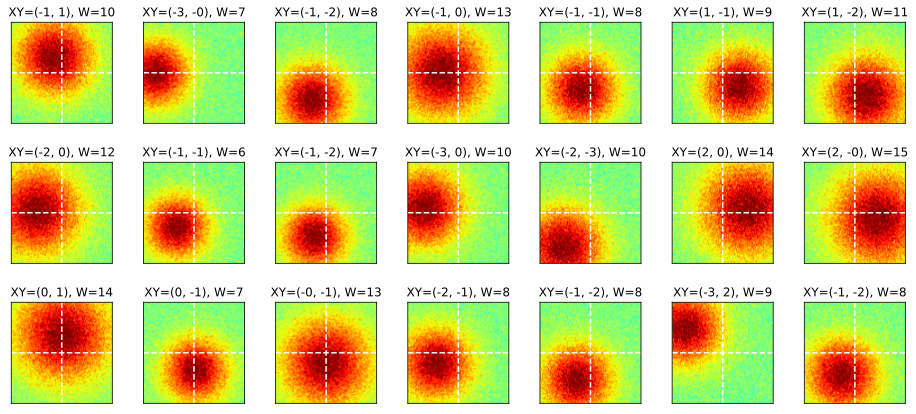

In [8]:
# visualize some images

fig, axs = plt.subplots(3, 7, figsize=(13, 6))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss)
    G = np.squeeze(images[whichpic, :, :])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet', extent=[-4, 4, -4, 4], origin='top')
    ax.set_title(f'XY=({labels[whichpic,0]:.0f}, {labels[whichpic,1]:.0f}), W={labels[whichpic,2]:.0f}')
    ax.plot([-4, 4], [0, 0], 'w--')
    ax.plot([0, 0], [-4, 4], 'w--')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## Create train/test groups using DataLoader

In [9]:
# step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into pyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Step 4: translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [10]:
# check size (should be images X channels X width X height)
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([900, 1, 91, 91])
torch.Size([900, 3])


## Create the DL model

In [30]:
 # create a class for the model
def makeTheNet():

    class gausnet(nn.Module):
        def __init__(self):
            super().__init__()

            # conv1
            self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
            # output size: (91 + 2 * 1 -3 ) / 1 + 1 = 91
            # post-pooling: 91/2 = 45

            # conv2
            self.conv2 = nn.Conv2d(6, 4, 3, padding=1)
            #output size: (45 + 2 * 1 - 3)/1 + 1 = 45
            #post-pooling: 45/2 = 22

            # fc1
            self.fc1 = nn.Linear(22*22*4, 50)

            # fc2
            self.fc2 = nn.Linear(50, 3)

            

        def forward(self, x):
            
            # first conv-pool set
            conv1act = F.relu(self.conv1(x))
            x = F.avg_pool2d(conv1act, (2, 2))

            # second conv-pool set
            conv2act = F.relu(self.conv2(x))
            x = F.avg_pool2d(conv2act, (2, 2))

            # ANN part
            x = x.reshape(x.shape[0], -1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)


            return x, conv1act, conv2act
 
    
    # create the model instance
    net = gausnet()

    # loss function
    lossfun = nn.MSELoss()

    # optimzier
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net, lossfun, optimizer



In [31]:
# test the model with one batch
net, lossfun, optimzier = makeTheNet()

X, y = iter(train_loader).next()
yHat, featmap1, featmap2 = net(X)

# check size of output
print(' ')
print(yHat.shape)
print('\nFeature map after conv1')
print(featmap1.shape)
print('\nFeature map after conv2')
print(featmap2.shape)

 
torch.Size([16, 3])

Feature map after conv1
torch.Size([16, 6, 91, 91])

Feature map after conv2
torch.Size([16, 4, 45, 45])


In [32]:
# count the total number of parametes in the model
summary(net, (1, imgSize, imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
            Conv2d-2            [-1, 4, 45, 45]             220
            Linear-3                   [-1, 50]          96,850
            Linear-4                    [-1, 3]             153
Total params: 97,283
Trainable params: 97,283
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


## Create a function that trains the model

In [33]:
# a function that trains the model

def function2trainTheModel():

    # number of epochs
    numepochs = 50

    # create a new model
    net, lossfun, optimizer = makeTheNet()

    # intialize losses
    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs) 


    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchLoss = []

        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)[0]
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

        # end of batch loop

        # and get average losses across the batches
        trainLoss[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        with torch.no_grad():           # deactivates autograd
            yHat = net(X)[0]
            loss = lossfun(yHat, y)

        # compare the following really long line of code to the training accuracy lines
        testLoss[epochi] = loss.item()

    # end of loop

    # function output
    return trainLoss, testLoss, net

In [34]:
## Run the model and show the results!

In [35]:
trainLoss, testLoss, net = function2trainTheModel()

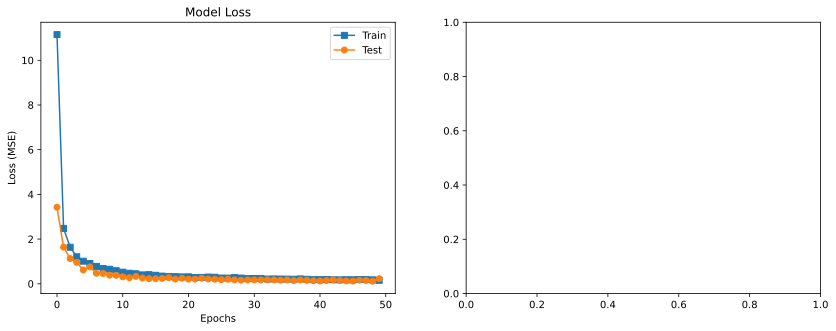

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(trainLoss, 's-', label='Train')
ax[0].plot(testLoss, 'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model Loss')
ax[0].legend()

plt.show()

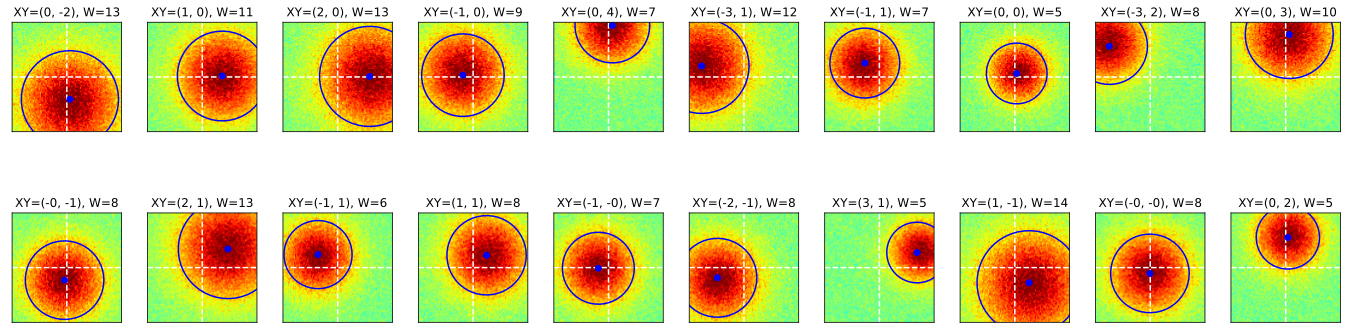

In [41]:
# visualize some images

X, y = next(iter(test_loader)) # extract X, y from test dataloader
yHat, featmap1, featmap2 = net(X)

fig, axs = plt.subplots(2, 10, figsize=(19, 6))

th = np.linspace(0, 2*np.pi)

for i, ax in enumerate(axs.flatten()):
    G = torch.squeeze(X[i, 0, :, :]).detach()
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet', extent=[-4, 4, -4, 4], origin='top')
    ax.set_title(f'XY=({yHat[i,0]:.0f}, {yHat[i,1]:.0f}), W={yHat[i,2]:.0f}')

    ax.plot([-4, 4], [0, 0], 'w--')
    ax.plot([0, 0], [-4, 4], 'w--')

    # compute the model's predictions
    cx = yHat[i][0].item()  # center X
    cy = yHat[i][1].item()  # center Y
    rd = yHat[i][2].item()  # radius

    # and draw it
    x = cx + np.cos(th) * np.sqrt(rd)
    y = cy + np.sin(th) * np.sqrt(rd)
    ax.plot(x, y, 'b')
    ax.plot(cx, cy, 'bo')

    # some final plotting niceties
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])

plt.tight_layout()
plt.show()

## Draw the feature maps

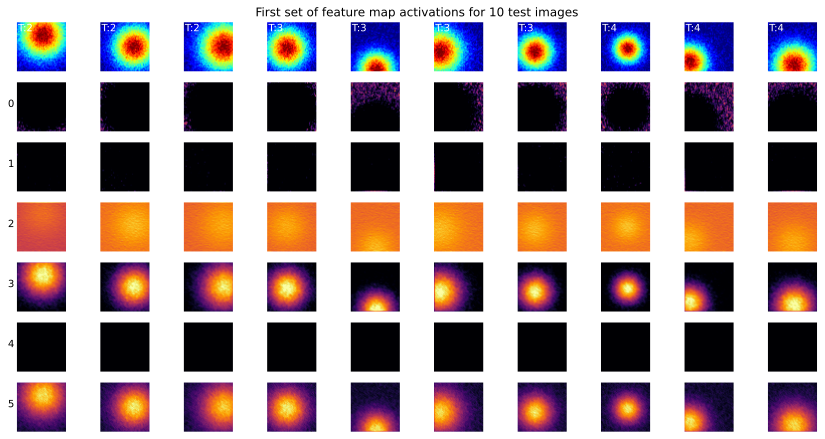

In [42]:
# feature maps from the conv1 layer

fig, axs = plt.subplots(7, 10, figsize=(12, 6))

for pici in range(10):

    # show the original picture
    img = X[pici, 0, :, :].detach()
    axs[0, pici].imshow(img, cmap='jet', vmin=0, vmax=1)
    axs[0, pici].axis('off')
    axs[0, pici].text(2,2, 'T:%s'%int(y[pici].item()), ha='left', va='top', color='w', fontweight=3)

    for feati in range(6):
        # extract the feature map from this image
        img = featmap1[pici, feati, :, :].detach()
        axs[feati+1, pici].imshow(img, cmap='inferno', vmin=0, vmax=torch.max(img)*.9)
        axs[feati+1, pici].axis('off')
        axs[feati+1, pici].text(-5, 45, feati, ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('First set of feature map activations for 10 test images', x=.5, y=1.01)
plt.show()

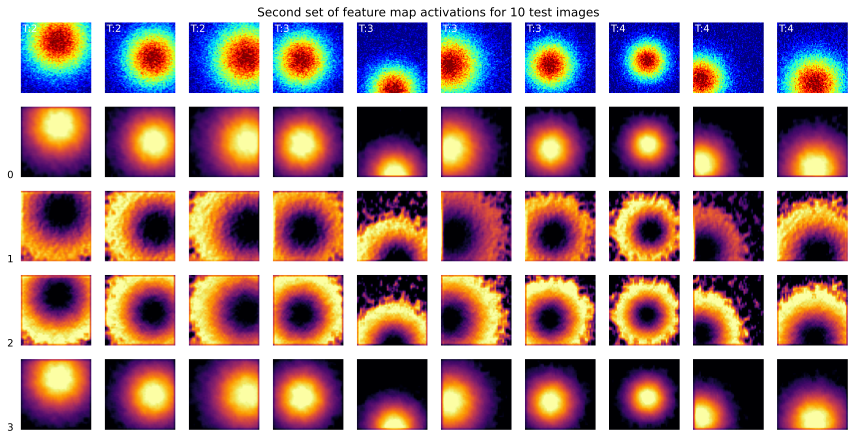

In [43]:
# feature maps from the conv1 layer

fig, axs = plt.subplots(5, 10, figsize=(12, 6))

for pici in range(10):

    # show the original picture
    img = X[pici, 0, :, :].detach()
    axs[0, pici].imshow(img, cmap='jet', vmin=0, vmax=1)
    axs[0, pici].axis('off')
    axs[0, pici].text(2,2, 'T:%s'%int(y[pici].item()), ha='left', va='top', color='w', fontweight=3)

    for feati in range(4):
        # extract the feature map from this image
        img = featmap2[pici, feati, :, :].detach()
        axs[feati+1, pici].imshow(img, cmap='inferno', vmin=0, vmax=torch.max(img)*.9)
        axs[feati+1, pici].axis('off')
        axs[feati+1, pici].text(-5, 45, feati, ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('Second set of feature map activations for 10 test images', x=.5, y=1.01)
plt.show()

## Spatial correlations across the feature maps

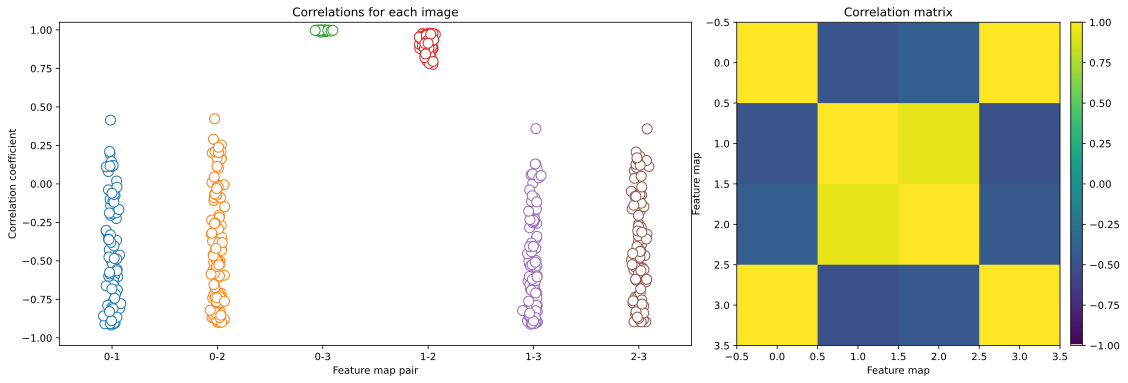

In [44]:
### correlations across the SECOND convolution layer

# convenient variables
nStim = featmap2.shape[0]
nMaps = featmap2.shape[1]
nCors = (nMaps*(nMaps-1))//2

## initialize the matrix of all correlation values
allrs = np.zeros((nStim, nCors))
Call = np.zeros((nMaps, nMaps))

# loop over each stimulus
for i in range(nStim):

    # extract the vectorized feature maps from this image
    featmaps = featmap2[i, :, :, :].view(nMaps, -1).detach()

    # compute the correlation matrix
    C = np.corrcoef(featmaps)
    Call += C

    # extract the unique correlations from the matrix
    idx = np.nonzero(np.triu(C, 1))
    allrs[i, :] = C[idx]

# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
    xlab.append('%s-%s'%(idx[0][i], idx[1][i]))

# now visualize the correlations
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_axes([.1, .1, .55, .9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68, .1, .3, .9])
cax = fig.add_axes([.98, .1, .01, .9])

for i in range(nCors):
    ax0.plot(i+np.random.randn(nStim)/30, allrs[:, i], 'o', markerfacecolor='w', markersize=10)

# make the plot more interpretatble 
ax0.set_xlim([-.5, nCors-.5])
ax0.set_ylim([-1.05, 1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')

# now show the average correlation matrix
h = ax1.imshow(Call/nStim, vmin=-1, vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h, cax=cax)

plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


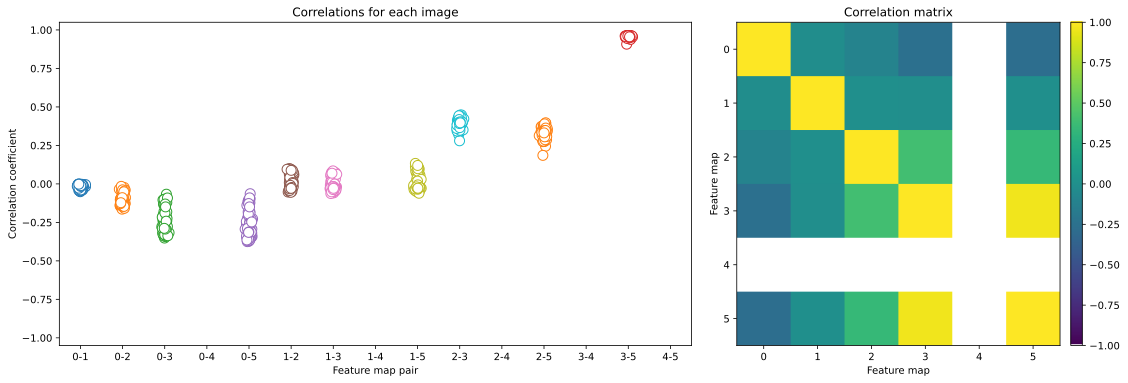

In [45]:
### correlations across the First convolution layer

# convenient variables
nStim = featmap1.shape[0]
nMaps = featmap1.shape[1]
nCors = (nMaps*(nMaps-1))//2

## initialize the matrix of all correlation values
allrs = np.zeros((nStim, nCors))
Call = np.zeros((nMaps, nMaps))

# loop over each stimulus
for i in range(nStim):

    # extract the vectorized feature maps from this image
    featmaps = featmap1[i, :, :, :].view(nMaps, -1).detach()

    # compute the correlation matrix
    C = np.corrcoef(featmaps)
    Call += C

    # extract the unique correlations from the matrix
    idx = np.nonzero(np.triu(C, 1))
    allrs[i, :] = C[idx]

# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
    xlab.append('%s-%s'%(idx[0][i], idx[1][i]))

# now visualize the correlations
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_axes([.1, .1, .55, .9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68, .1, .3, .9])
cax = fig.add_axes([.98, .1, .01, .9])

for i in range(nCors):
    ax0.plot(i+np.random.randn(nStim)/30, allrs[:, i], 'o', markerfacecolor='w', markersize=10)

# make the plot more interpretatble 
ax0.set_xlim([-.5, nCors-.5])
ax0.set_ylim([-1.05, 1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')

# now show the average correlation matrix
h = ax1.imshow(Call/nStim, vmin=-1, vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h, cax=cax)

plt.show()